Validación de la selección de sondas por triangulacion
Implementa el algoritmo de triangulaacion 2018) de Masetti, G., Faulkes, T., & Kastrisios, C. (2018). *Automated Identification of Discrepancies between Nautical Charts and Survey Soundings. ISPRS International Journal of Geo-Information, 7(10), 392 *
https://www.mdpi.com/2220-9964/7/10/392/pdf

Por Luis Rioja Gallo, mayo 2022

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point,LineString, MultiPoint, MultiPolygon
from shapely.ops import triangulate
import rasterio
import rasterio.mask
import math

# Funcion de redondeo OHI

In [2]:
def truncado(z):
    if z<=0.099 and z>=0.001:
        z=int(0)
    elif z>0.099 and z< 21:
        b=z-int(z)
        b=b*10
        r=math.floor(b)/10
        if r==0:
            r=int(z)
        else:
            r=int(z)+r
        z=r
    elif z>=21 and z<31:
        b=z-int(z)
        b=b*10
        r=math.floor(b)/10
        if r==0:
            r=int(z)
        else:
            if r<0.5:
                r=int(z)
            else:
                r=int(z)+r
        z=r
    elif z>=31:
        z=int(z)
    else:
        z2=abs(z)
        b=z2-int(z2)
        b=b*10
        r1=math.ceil(b)/10
        if r1==0:
            r=int(z2)
        else:
            r=int(z2)+r1
        z=-r
        if int(z)-z==0:
            z=int(z)
    return z

# Introducir la rutas y nombres de los archivos de sondas, landare, coalne,y covr

In [3]:
selec='SOUNDG.geojson'
lndare='ThunderBay_LNDARE.geojson'
coalne='ThunderBay_COALNE.geojson'
covr='ThunderBay_M_COVR.geojson'
df_selec=gpd.read_file(selec)
df_lndare=gpd.read_file(lndare)
df_coalne=gpd.read_file(coalne)


# En caso de no tener la batimetría recortada, primero recorta por LNDARE y luego por COVR

In [4]:
import fiona
with fiona.open(lndare, "r") as geojson:
    for feature in geojson:
        shapes= [feature["geometry"]]
        with rasterio.open("NONNA10_4840N08920W.tiff") as src:
            out_image, out_transform= rasterio.mask.mask(src, shapes, invert=True, crop=False)
            out_meta = src.meta

        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
        nombre='recortado.tiff'

        with rasterio.open(nombre, "w", **out_meta) as dest:
            dest.write(out_image)
with fiona.open(covr, "r") as geojson:
    for feature in geojson:
        shapes= [feature["geometry"]]
        with rasterio.open("recortado.tiff") as src:
            out_image, out_transform= rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta

        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
        nombre='recortado_total.tiff'

        with rasterio.open(nombre, "w", **out_meta) as dest:
            dest.write(out_image)        

geojson.close()


# Convierte el geojson en geoseries con point_z y luego un shapely de multipoints

In [5]:
pts=gpd.GeoSeries(df_selec['geometry'])
depth=df_selec['DEPTH']
puntos=[]
for i in range(len(pts)):
    puntos.append(list(pts[i].coords))
puntos_z=[]
for i in range(len(puntos)):
    dp=truncado(depth[i])
    puntos_z.append(puntos[i][0]+(dp,))
points=MultiPoint(puntos_z)    


# triangulacion con shapely y creacion de mascara de triangulos invalidos, corta por "lndare"

In [6]:
triangles=triangulate(points, edges=False)
lnd=gpd.GeoSeries(df_lndare['geometry'])
tri=gpd.GeoSeries(triangles, crs=lnd.crs)
mask=[]
for i in range(len(tri)):
    res=lnd.intersects(tri[i])
    if res[0]==False:
        mask.append(True)
    else:
        mask.append(False)
tri2=tri[mask]

# Pasa tiff a point_cloud tipo multipoint de shapely

In [7]:
dest.close()
point_cloud=[]
src = rasterio.open("recortado_total.tiff")
noval=src.nodata
band1=src.read(1)
exten=src.shape
w=exten[0]
h=exten[1]
    
for i in range(w):
    for j in range (h):
        a=src.xy(i,j) 
        row, col = src.index(a[0],a[1])
        d=band1[row, col]
        if d!=noval:
            dt=truncado(d)
            point_cloud.append([a[0],a[1],-dt])
src.close() 
baty=MultiPoint(point_cloud)


            
# Algoritmo de busqueda de mínimas dentro de cada triangulo



In [8]:
import pyprind
warning_soundg=[]
control=[]
ind=tri2.index
bar=pyprind.ProgBar(len(ind),monitor=True, title='Comprobando minimas')
for i in range(len(ind)):
    a=tri2[ind[i]].intersection(baty)
    minima=[]
    for k in range(len(list(tri2[ind[i]].exterior.coords))):
        minima.append(list(tri2[ind[i]].exterior.coords)[k][2])
    if a.type!='Point':
        for j in range(len(a.geoms)):
            if a.geoms[j].z < min(minima) and [a.geoms[j].x,a.geoms[j].y,a.geoms[j].z] not in warning_soundg:
                warning_soundg.append([a.geoms[j].x,a.geoms[j].y,a.geoms[j].z])
                control.append(min(minima))
   
    bar.update(1)

Comprobando minimas
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:10:22


# Creacion de fichero geojson  

In [9]:
warn_dict={}
for i in range(len(warning_soundg)):
    warn_dict[i]={'DEPTH': warning_soundg[i][2], 'geometry':Point(warning_soundg[i][0],warning_soundg[i][1]) }
w_s = gpd.GeoDataFrame(warn_dict, crs=lnd.crs).transpose()
w_s.to_file('warning6.geojson', driver='GeoJSON')

C:\Users\monoc\AppData\Local\Temp\ipykernel_45108\3240316343.py:4: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  w_s = gpd.GeoDataFrame(warn_dict, crs=lnd.crs).transpose()
C:\Users\monoc\.conda\envs\geospatial\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'warning6.geojson'

# Representacion final

<AxesSubplot:>

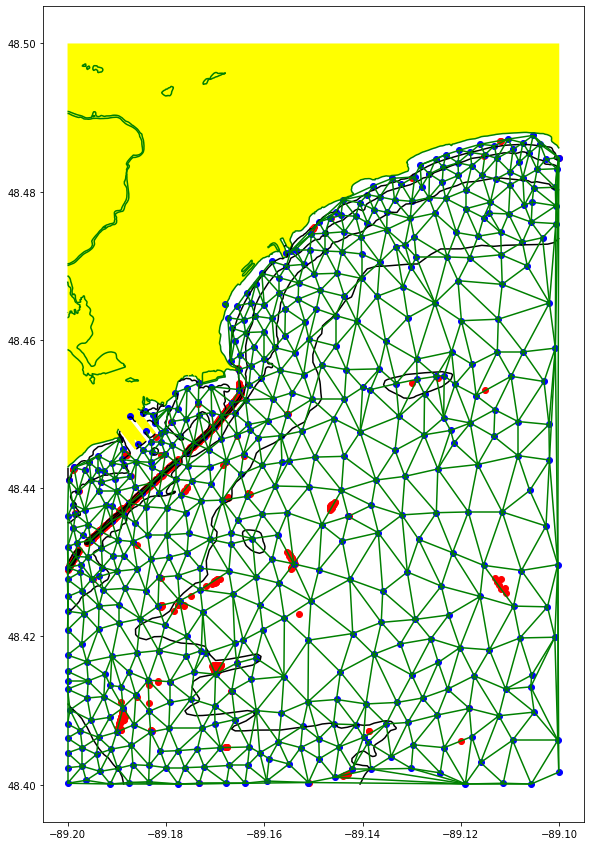

In [287]:
triangles2=triangulate(points, edges=True)
lnd=gpd.GeoSeries(df_lndare['geometry'])
tri_mat=gpd.GeoSeries(triangles2, crs=lnd.crs)
mask2=[]
for i in range(len(tri_mat)):
    res=lnd.intersects(tri_mat[i])
    if res[0]==False:
        mask2.append(True)
    else:
        mask2.append(False)
tri2_mat=tri_mat[mask2]

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()

df_lndare.plot(ax=ax, color='yellow')
df_coalne.plot(ax=ax, color='green')
df_depcnt.plot(ax=ax, color='black')
tri2_mat.plot(ax=ax, color='green')
w_s.plot(ax=ax,color='red')
df_selec.plot(ax=ax, color='blue', figsize=(12,12))